In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, sosfiltfilt, find_peaks

def break_correct(data):
    corrected_data = np.copy(data)
    for i in range(1, len(data)):
        diff = data[i] - data[i - 1]
        if diff < -180:  # Assuming a break from 360 to 0
            corrected_data[i:] += 360
        elif diff > 180:  # Assuming a break from 0 to 360
            corrected_data[i:] -= 360
    return corrected_data

def signal_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='high', analog=False, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

In [25]:
file_path = '../../dataset/basketball/test-2024-01-10-16-01-28.csv'
data = pd.read_csv(file_path).to_numpy()
timestamps = (data[:, 0] - data[0, 0])/ 1000
timestamps = np.linspace(0, timestamps[-1], len(timestamps))
c = data[:, 1]
b = data[:, 2]
tl = data[:, 3]
tr = data[:, 4]
r = data[:, 5]
p = data[:, 6]
y = data[:, 7]

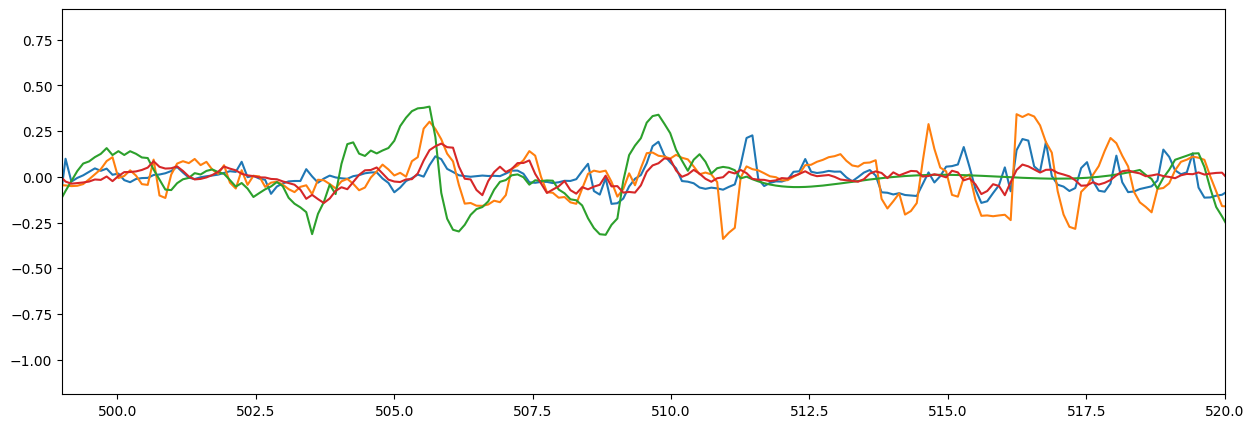

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(timestamps, signal_filter(c, 0.2, 10))
plt.plot(timestamps, signal_filter(b, 0.2, 10))
plt.plot(timestamps, signal_filter(tl, 0.2, 10))
plt.plot(timestamps, signal_filter(tr, 0.2, 10))

plt.xlim(499, 520)
plt.show()

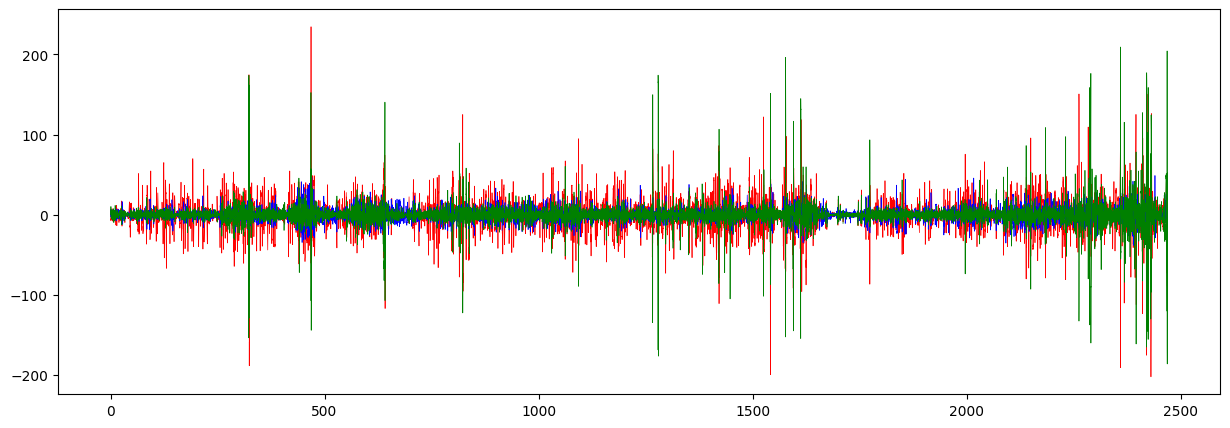

In [27]:
yf = break_correct(y)

# Highpass filter to remove drift (assuming sampling rate of 100 Hz, and cutoff frequency of 0.1 Hz)
fs = 10
cutoff = 0.2
yf = signal_filter(yf, cutoff, fs)
pf = signal_filter(p, cutoff, fs)
rf = signal_filter(r, cutoff, fs)

plt.figure(figsize=(15, 5))
# plt.plot(timestamps, y, 'r--', lw=0.5)
# plt.plot(timestamps, p, 'b--', lw=0.5)
# plt.plot(timestamps, r, 'g--', lw=0.5)
plt.plot(timestamps, yf, 'r', lw=0.5)
plt.plot(timestamps, pf, 'b', lw=0.5)
plt.plot(timestamps, rf, 'g', lw=0.5)


# plt.xlim(264, 300)

(400.0, 500.0)

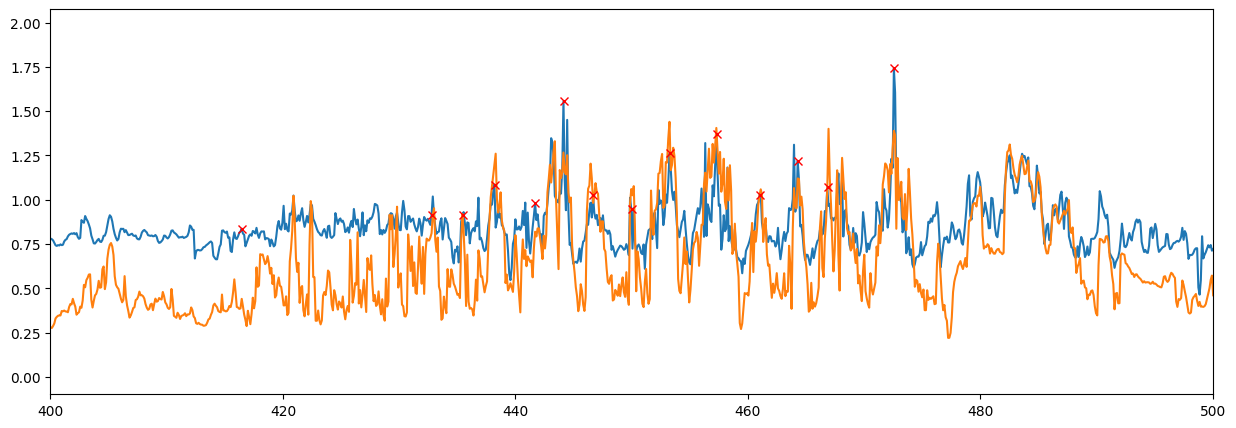

In [28]:
plt.figure(figsize=(15, 5))

events = pd.read_csv('../videos/basketball/data_points.csv', header=None).to_numpy().squeeze()
plt.plot(timestamps, c)
plt.plot(timestamps, b)
for event in events:
    plt.plot(event, c[np.where(np.abs(timestamps - event) <= 8e-2)[0][0]], 'rx')

plt.xlim(400, 500)

In [29]:
import sys
sys.path.insert(1, '../../')
from utils import *
_, c1 = upsample(timestamps, c, 100)
_, b1 = upsample(timestamps, b, 100)
_, tl1 = upsample(timestamps, tl, 100)
_, tr1 = upsample(timestamps, tr, 100)
_, y1 = upsample(timestamps, yf, 100)
_, p1 = upsample(timestamps, pf, 100)
_, r1 = upsample(timestamps, rf, 100)
timestamps1, _ = upsample(timestamps, timestamps, 100)

In [30]:
data1 = np.column_stack((c1, b1, tl1, tr1, y1, p1, r1))
data1.shape

(2328701, 7)

In [31]:
# time period for each activity, [start_idx, end_idx]
jogging = [580000, 670000]
resting = [670000, 780000]
shooting = [780000, 1184000]
layup = [1184000, 1560000]

In [32]:
timestamps2 = timestamps1 * 0.001 / (timestamps1[1] - timestamps1[0])
events1 = events * 0.001 / (timestamps1[1] - timestamps1[0])

In [33]:
import scipy

def manual_find_peaks(activity, height=None, distance=None):
    b_ = b1[activity[0]:activity[1]]
    timestamps_ = timestamps2[activity[0]:activity[1]]
    idx, vals = scipy.signal.find_peaks(b_, height=height, distance=distance)
    plt.plot(timestamps_, b_)
    plt.plot(timestamps_[idx], b_[idx], marker="o", ls="", ms=3)
    return timestamps_[idx], idx

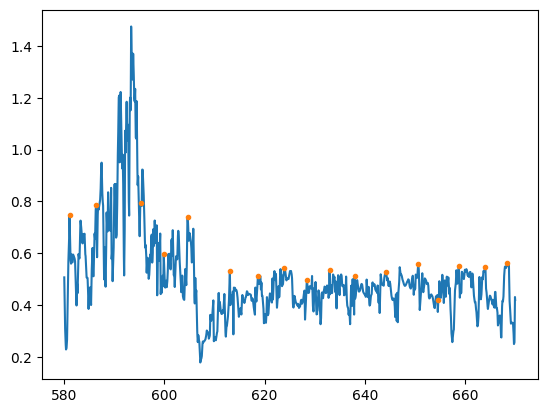

In [34]:
jogging_peak_time, jogging_peak = manual_find_peaks(jogging, [0.4, 0.8], 4000)

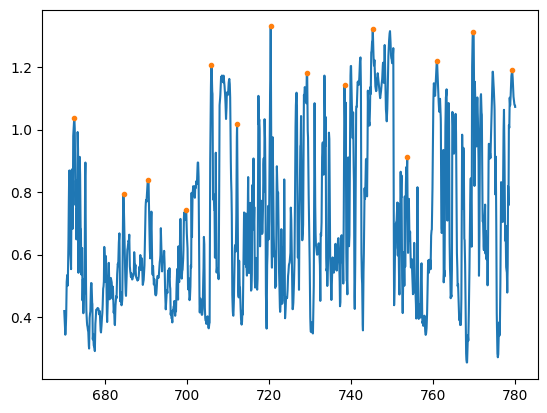

In [35]:
resting_peak_time, resting_peak = manual_find_peaks(resting, distance=6000)

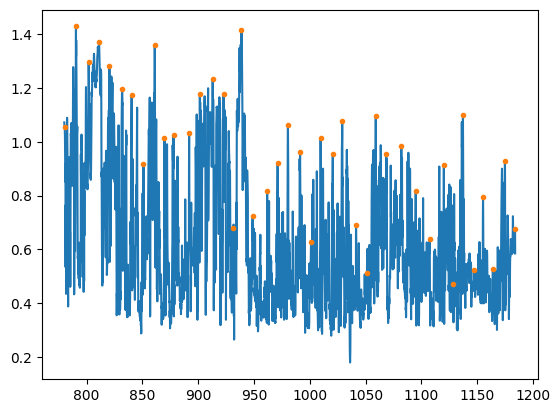

In [36]:
shooting_peak_time, shooting_peak = manual_find_peaks(shooting, distance=8000)

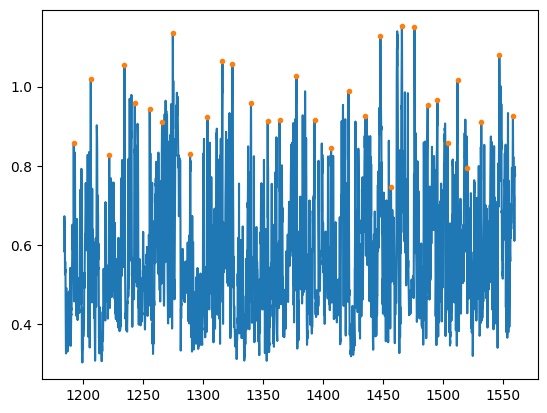

In [37]:
layup_peak_time, layup_peak = manual_find_peaks(layup, distance=8000)

In [38]:
cough_peak_time = np.array(pd.read_csv('../videos/basketball/data_points.csv')).squeeze()

In [39]:
peak_time = np.concatenate([cough_peak_time, jogging_peak_time, resting_peak_time, shooting_peak_time, layup_peak_time])[:, np.newaxis]
peak_time.shape

(175, 1)

In [40]:
# cough 2, resting 1, jogging/shooting/layup 4
jogging_peak_time.shape
peak_activities = np.array(([2] * cough_peak_time.size) + ([4] * jogging_peak_time.size) + ([1] * resting_peak_time.size) + ([4] * shooting_peak_time.size) + ([4] * layup_peak_time.size))[:, np.newaxis]
peak_activities.shape

(175, 1)

In [41]:
peak_time_activities = np.concatenate([peak_time, peak_activities], axis=1)
peak_time_activities.shape

(175, 2)

In [42]:
np.all(peak_time_activities[:,0][:-1] <= peak_time_activities[:,0][1:])

False

In [43]:
peak_time_activities_sorted = peak_time_activities[peak_time_activities[:, 0].argsort()]
np.all(peak_time_activities_sorted[:,0][:-1] <= peak_time_activities_sorted[:,0][1:])

True

In [45]:
peak_time_activities[peak_time_activities[:, 1] == 2]

array([[264.  ,   2.  ],
       [266.5 ,   2.  ],
       [268.4 ,   2.  ],
       [271.2 ,   2.  ],
       [273.  ,   2.  ],
       [275.2 ,   2.  ],
       [277.8 ,   2.  ],
       [279.9 ,   2.  ],
       [282.  ,   2.  ],
       [283.9 ,   2.  ],
       [286.2 ,   2.  ],
       [288.2 ,   2.  ],
       [290.2 ,   2.  ],
       [291.8 ,   2.  ],
       [294.5 ,   2.  ],
       [296.2 ,   2.  ],
       [298.  ,   2.  ],
       [300.  ,   2.  ],
       [302.1 ,   2.  ],
       [304.1 ,   2.  ],
       [306.5 ,   2.  ],
       [308.6 ,   2.  ],
       [310.4 ,   2.  ],
       [312.3 ,   2.  ],
       [313.8 ,   2.  ],
       [315.9 ,   2.  ],
       [317.9 ,   2.  ],
       [320.4 ,   2.  ],
       [322.8 ,   2.  ],
       [324.9 ,   2.  ],
       [326.5 ,   2.  ],
       [329.3 ,   2.  ],
       [416.5 ,   2.  ],
       [432.8 ,   2.  ],
       [435.5 ,   2.  ],
       [438.2 ,   2.  ],
       [441.7 ,   2.  ],
       [444.2 ,   2.  ],
       [446.7 ,   2.  ],
       [450.  ,   2.  ],


Text(0, 0.5, 'Angles ($\\circ$)')

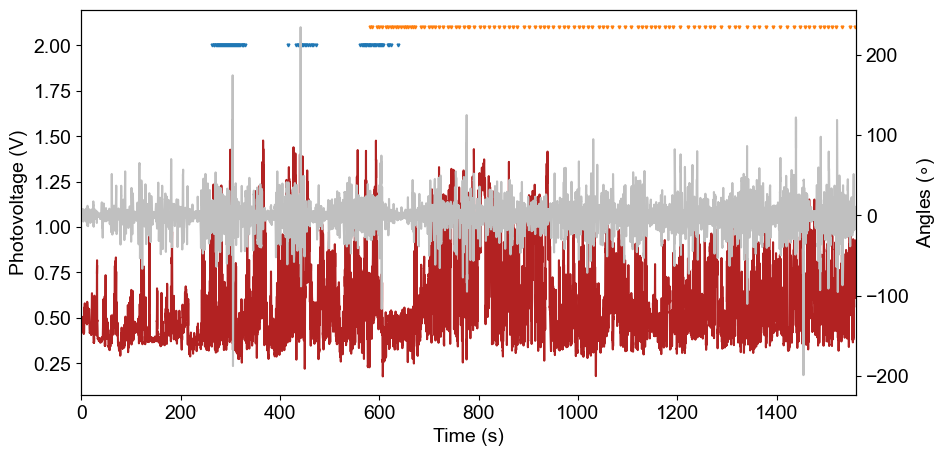

In [46]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
plt.plot(timestamps2, b1, c='firebrick')
plt.plot(peak_time_activities[peak_time_activities[:, 1] == 2][:, 0],
         2 * np.ones_like(peak_time_activities[peak_time_activities[:, 1] == 2][:, 0]),
         'v', ms=2)
plt.plot(peak_time_activities[peak_time_activities[:, 1] != 2][:, 0],
         2.1 * np.ones_like(peak_time_activities[peak_time_activities[:, 1] != 2][:, 0]),
         'v', ms=2)
plt.xlim([0, 1560])
plt.xlabel('Time (s)')
plt.ylabel('Photovoltage (V)')

ax = ax.twinx()
plt.plot(timestamps2, y1, c='silver')
plt.ylabel('Angles ($\circ$)')

In [47]:
peak_time.squeeze().shape

(175,)

In [48]:
timestamps2.shape

(2328701,)

In [49]:
window_width = 3000
expanded_peaks = peak_expand((peak_time*1000).squeeze().astype(int) - 1, window_width, len(timestamps2))

slices = []
for idx in range(expanded_peaks.shape[0]):
    slices.append(data1[expanded_peaks[idx, :]])
slices = np.array(slices)

slices.shape

(175, 3000, 7)

In [56]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

print(torch.__version__)
print(torch.__config__.show())
print(f'PyTorch is running on {device}')

2.1.1
PyTorch built with:
  - GCC 4.2
  - C++ Version: 201703
  - clang 13.1.6
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: NO AVX
  - Build settings: BLAS_INFO=accelerate, BUILD_TYPE=Release, CXX_COMPILER=/Applications/Xcode_13.3.1.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++, CXX_FLAGS= -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DUSE_PYTORCH_METAL_EXPORT -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -DUSE_COREML_DELEGATE -O2 -fPIC -Wall -Wextra -Werror=return-type -Werror=non-virtual-dtor -Werror=braced-scalar-init -Werror=range-loop-construct -Werror=bool-operation -Wnarrowing -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-unused-parameter -Wno-unused-function -Wno-unused-result -Wno-strict-overflow -Wno-strict-aliasing -Wvla-extension -Wnewline-eof -Winconsistent-missi

In [57]:
class BaseLHMDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

class LHMDualDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        photovoltage_data = self.features[idx, :4, :].float().transpose(0, 1)  # First 4 channels
        euler_angle_data = self.features[idx, 4:, :].float().transpose(0, 1)  # Last 3 channels
        return photovoltage_data, euler_angle_data, self.labels[idx]
    
features = torch.tensor(slices).permute(0, 2, 1).type(torch.LongTensor)
labels = torch.tensor(peak_time_activities[:, 1]).type(torch.LongTensor)

print(features.shape)
print(labels.shape)

dual_ds = LHMDualDataset(features, labels)
dual_ds.features.shape

torch.Size([175, 7, 3000])
torch.Size([175])


torch.Size([175, 7, 3000])

In [58]:
input_dim1 = 4 # For photovoltage data
input_dim2 = 3 # For Euler angle data
hidden_dim = 140
layer_dim = 1
output_dim = 6 # Number of classes
dropout_prob = 0

num_epochs = 400

# Preparing data
batch_size = 32

total_samples = len(dual_ds)
test_size = int(0.3 * total_samples)
train_size = total_samples - test_size

train_dataset_dual, test_dataset_dual = random_split(dual_ds, [train_size, test_size])
train_loader_dual = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=True)
test_loader_dual = DataLoader(test_dataset_dual, batch_size=batch_size, shuffle=False)

In [59]:
import torch.nn as nn

class DualGRUModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # GRU layers
        self.gru1 = nn.GRU(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.gru2 = nn.GRU(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states for both GRUs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.gru1(x1, h01.detach())
        out2, _ = self.gru2(x2, h02.detach())

        # Concatenate the outputs from both GRUs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

In [61]:
# Container for losses and accuracies
train_losses_gru_dual = []
train_accuracies_gru_dual = []
test_losses_gru_dual = []
test_accuracies_gru_dual = []

# Model definition
model_gru_dual = DualGRUModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
criterion = nn.CrossEntropyLoss()
optimizer_dual = torch.optim.Adam(model_gru_dual.parameters(), lr=0.0001, weight_decay=0.01)
print(model_gru_dual.to(device))

for epoch in range(num_epochs):
    model_gru_dual.train()  # Set the model to training mode
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for photovoltage_data, euler_angle_data, labels in train_loader_dual:
        # Load data
        photovoltage_data = photovoltage_data.to(device)
        euler_angle_data = euler_angle_data.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_gru_dual(photovoltage_data, euler_angle_data)
        loss = criterion(outputs, labels.squeeze())

        # Backward pass and optimization
        optimizer_dual.zero_grad()
        loss.backward()
        optimizer_dual.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader_dual)
    train_accuracy = total_train_correct / total_train_samples
    train_losses_gru_dual.append(avg_train_loss)
    train_accuracies_gru_dual.append(train_accuracy)

    model_gru_dual.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for photovoltage_data, euler_angle_data, labels in test_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device).float()
            euler_angle_data = euler_angle_data.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model_gru_dual(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

    avg_test_loss = total_test_loss / len(test_loader_dual)
    test_accuracy = total_test_correct / total_test_samples
    test_losses_gru_dual.append(avg_test_loss)
    test_accuracies_gru_dual.append(test_accuracy)

    # Print training and testing statistics for each epoch
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

DualGRUModel(
  (gru1): GRU(4, 140, batch_first=True)
  (gru2): GRU(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)


KeyboardInterrupt: 